In [1]:
import numpy
import pandas
import math
from datetime import datetime
import pandas_datareader.data as web
import xlrd

/home/justus/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%load_ext autoreload
%autoreload 2
import bond_simulator

In [3]:
import seaborn
from matplotlib import pyplot as plt
seaborn.set(style='whitegrid')
seaborn.set_context('poster')

# OECD Short

These are 3-month rates.

In [4]:
oecd_short = pandas.read_excel('OECD IMF RoE Interest Rates.xlsx',
                          usecols='A,F,G',
                          parse_dates=['TIME'],
                          sheet_name='DP_LIVE_ShortM',
                          converters = {'Value': lambda x: x/100}
                         )

In [5]:
def get_country(country, df):
    cc = df[df['LOCATION'] == country].sort_values('TIME')
    return pandas.Series(data=cc['Value'].values, index=cc['TIME'])
get_country('USA', oecd_short).head()

TIME
1964-06-01    0.0386
1964-07-01    0.0387
1964-08-01    0.0385
1964-09-01    0.0387
1964-10-01    0.0394
dtype: float64

# OECD Long

These are 10-year rates.

In [6]:
oecd_long = pandas.read_excel('OECD IMF RoE Interest Rates.xlsx',
                          usecols='A,F,G',
                          parse_dates=['TIME'],
                          sheet_name='DP_LIVE_LongM',
                          converters = {'Value': lambda x: x/100}
                         )

In [7]:
get_country('USA', oecd_long).head()

TIME
1953-04-01    0.0283
1953-05-01    0.0305
1953-06-01    0.0311
1953-07-01    0.0293
1953-08-01    0.0295
dtype: float64

# IMF Rates

This sheet contains "bond", "bill", and "money market" rates. We need to do some extra processing here to get everything in the right shape for us to use.

* "bond" maturity is ???
* "bill" maturity is anywhere from 3- to 12-months depending on the country
* "money market" maturity is (presumably?) overnight or 1-month?

In [8]:
imf = pandas.read_excel('OECD IMF RoE Interest Rates.xlsx',
                        sheet_name='IMF Monthly',
                        usecols='A,F,H:AKF', # Warning! AKF goes to January 2020 only.
                        skipfooter=18
                         )
imf.head()

,Unnamed: 0,Indicator Code,1940M1,1940M2,1940M3,1940M4,1940M5,1940M6,1940M7,1940M8,...,2019M4,2019M5,2019M6,2019M7,2019M8,2019M9,2019M10,2019M11,2019M12,2020M1
0,AUS,FIGB_PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.86,1.65,1.38,1.31,0.95,1.03,1.03,1.15,NaN,NaN
1,AUS,FITB_PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,FIMM_PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.50,1.50,1.28,1.02,1.00,1.00,0.76,0.75,NaN,NaN
3,AUT,FIGB_PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
imf = imf.rename(columns={'Unnamed: 0': 'Country'})

def slice_imf(df, indicator_code):
    df_slice = df[df['Indicator Code'] == indicator_code]
    dates = [datetime.strptime(x, '%YM%m') for x in df_slice.T.index[2:]]
    n = pandas.DataFrame(columns=df_slice['Country'], data=df_slice.T[2:].values, index=dates)
    return n.applymap(lambda x: x / 100)

imf_bonds = slice_imf(imf, 'FIGB_PA')
imf_moneymarket = slice_imf(imf, 'FIMM_PA')
imf_bills = slice_imf(imf, 'FITB_PA')
imf_moneymarket.dropna().head()

Country,AUS,AUT,BEL,CAN,DNK,FRA,DEU,ITA,JPN,NLD,NOR,ESP,SWE,CHE,GBR,USA
1975-09-01,0.0981,0.04750,0.0433,0.076964,0.0462,0.0692,0.0433,0.0928,0.09667,0.0137,0.053,0.06692,0.071,0.0268,0.0586,0.0624
1975-10-01,0.0892,0.04500,0.0450,0.083929,0.0423,0.0668,0.0333,0.0860,0.08731,0.0515,0.056,0.06750,0.071,0.0305,0.0589,0.0582
1975-11-01,0.0983,0.04500,0.0388,0.085000,0.0129,0.0674,0.0339,0.0830,0.07609,0.0452,0.050,0.07971,0.053,0.0315,0.0591,0.0522
1975-12-01,0.0943,0.04750,0.0394,0.092321,0.0449,0.0645,0.0392,0.0833,0.07963,0.0482,0.065,0.08328,0.060,0.0337,0.0599,0.0520
1976-01-01,0.0680,0.04125,0.0399,0.091429,0.0500,0.0636,0.0358,0.0825,0.07283,0.0392,0.032,0.11663,0.059,0.0145,0.0632,0.0487


In [10]:
def make_series(country):
    short = imf_bills[country].combine_first(get_country(country, oecd_short)).dropna()
    long = imf_bonds[country].combine_first(get_country(country, oecd_long)).dropna()

    df = pandas.DataFrame(columns=range(1,11), data={1: short, 10: long}, dtype=numpy.float64)
    df = df.fillna(method='backfill', axis=0) # fill UP along a column, guarantees we have some kind of yield curve
    #df = df.dropna(thresh=2) # we might only have 1 rate (i.e. only short or only long; skip those years)
    df.interpolate(axis=1, inplace=True)
    #df.fillna(method='backfill', axis=1, inplace=True)
    return df

Prefer IMF rates. Are there any cases where we have OECD rates but not IMF rates?

In [11]:
make_series('USA')['1953':]

,1,2,3,4,5,6,7,8,9,10
1953-01-01,0.0204,0.021278,0.022156,0.023033,0.023911,0.024789,0.025667,0.026544,0.027422,0.0283
1953-02-01,0.0202,0.021100,0.022000,0.022900,0.023800,0.024700,0.025600,0.026500,0.027400,0.0283
1953-03-01,0.0208,0.021633,0.022467,0.023300,0.024133,0.024967,0.025800,0.026633,0.027467,0.0283
1953-04-01,0.0218,0.022522,0.023244,0.023967,0.024689,0.025411,0.026133,0.026856,0.027578,0.0283
1953-05-01,0.0220,0.022944,0.023889,0.024833,0.025778,0.026722,0.027667,0.028611,0.029556,0.0305
...,...,...,...,...,...,...,...,...,...,...
2019-09-01,0.0193,0.019044,0.018789,0.018533,0.018278,0.018022,0.017767,0.017511,0.017256,0.0170
2019-10-01,0.0168,0.016833,0.016867,0.016900,0.016933,0.016967,0.017000,0.017033,0.017067,0.0171
2019-11-01,0.0155,0.015789,0.016078,0.016367,0.016656,0.016944,0.017233,0.017522,0.017811,0.0181
2019-12-01,0.0154,0.015756,0.016111,0.016467,0.016822,0.017178,0.017533,0.017889,0.018244,0.0186


In [12]:
# given a series of yearly columns, convert it to monthly columns
def explode_series(annual_series):
    years = len(annual_series.columns)
    df = pandas.DataFrame(index=annual_series.index, columns=range(1, 12 * years + 1), dtype=numpy.float64)
    for index, cols in annual_series.iterrows():
        for year, rate in cols.iteritems():
            df.loc[index][year * 12] = rate
    df.interpolate(axis=1, inplace=True)
    return df.fillna(method='backfill', axis=1)

# we need to change the yields from annual yields to monthly yields
def make_yield_monthly(df):
    return df.applymap(lambda x: math.pow(1+x, 1/12) - 1)

In [13]:
country = 'USA'
short = imf_bills[country].combine_first(get_country(country, oecd_short)).dropna()
long = imf_bonds[country].combine_first(get_country(country, oecd_long)).dropna()
df = pandas.DataFrame(columns=range(1,11), data={1: short, 10: long}, dtype=numpy.float64)
#df = df.fillna(method='backfill', axis=0)
df.interpolate(axis=1, inplace=True)
df.fillna(method='backfill', axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10
1950-01-01,0.0109,0.0109,0.0109,0.0109,0.0109,0.0109,0.0109,0.0109,0.0109,0.0109
1950-02-01,0.0113,0.0113,0.0113,0.0113,0.0113,0.0113,0.0113,0.0113,0.0113,0.0113
1950-03-01,0.0114,0.0114,0.0114,0.0114,0.0114,0.0114,0.0114,0.0114,0.0114,0.0114
1950-04-01,0.0116,0.0116,0.0116,0.0116,0.0116,0.0116,0.0116,0.0116,0.0116,0.0116
1950-05-01,0.0117,0.0117,0.0117,0.0117,0.0117,0.0117,0.0117,0.0117,0.0117,0.0117


# debug what is wrong with USA, GBR, CAN

In [14]:
country_name = 'USA'
annual_yields = make_series(country_name)
exploded_yields = explode_series(annual_yields)
monthly_yields = make_yield_monthly(exploded_yields)
country_m = bond_simulator.simulate_turnover((12*10), (12*4), monthly_yields)
country_m.to_csv(f'{country_name.lower()}-monthly.csv')
country_m.head()

,NAV,Change,Maturity,Coupon,YTM,Duration
1950-01-01,11412.289347,0.002141,7.086005,0.027410,0.022513,6.412518
1950-02-01,11436.725855,0.002670,7.087602,0.027431,0.022649,6.413541
1950-03-01,11467.262106,0.002487,7.089115,0.027437,0.022685,6.414687
1950-04-01,11495.786813,0.002662,7.090572,0.027447,0.022754,6.415728
1950-05-01,11526.386230,0.002839,7.091965,0.027453,0.022790,6.416783


In [15]:
# aggregate monthly changes to an annual change
# or...could just compare NAV via a shift.
s = country_m['Change'] + 1
g = s.groupby(numpy.arange(len(s))//12, axis=0).prod()
g = g - 1
g.index = pandas.date_range(country_m.index[0], periods=len(g), freq='AS-JAN')
g

1950-01-01    0.028882
1951-01-01    0.027670
1952-01-01    0.025958
1953-01-01    0.063585
1954-01-01    0.022761
                ...   
2016-01-01    0.004148
2017-01-01    0.005308
2018-01-01    0.008922
2019-01-01    0.079790
2020-01-01    0.000000
Freq: AS-JAN, Name: Change, Length: 71, dtype: float64

# Annual turnover

In [16]:
country_name = 'USA'
annual = make_series(country_name)[::12]
country_a = bond_simulator.simulate_turnover(10, 4, annual)
country_a.to_csv(f'{country_name.lower()}-annual.csv')
country_a.head()

,NAV,Change,Maturity,Coupon,YTM,Duration
1950-01-01,13518.491892,0.027292,7.111555,0.027149,0.020856,6.506788
1951-01-01,13887.439951,0.026463,7.126012,0.027348,0.022168,6.516428
1952-01-01,14254.947838,0.024599,7.132966,0.027545,0.023459,6.520149
1953-01-01,14605.610762,0.060212,7.133534,0.027775,0.024949,6.518336
1954-01-01,15485.044248,0.022946,7.128343,0.026852,0.019423,6.526775


In [17]:
def plot_all(key, monthly, annual, title=None):
    g = monthly[key].groupby(numpy.arange(len(s))//12, axis=0).mean()
    g.index = pandas.date_range(monthly.index[0], periods=len(g), freq='AS-JAN')
    
    if not title:
        title = key

    plt.figure(figsize=(11,9))
    plt.title(title)
    seaborn.lineplot(data=pandas.DataFrame(data={
        'Annual': annual[key],
        'Monthly (January)': monthly[key][::12],
        'Monthly (Average)': g
    }))   

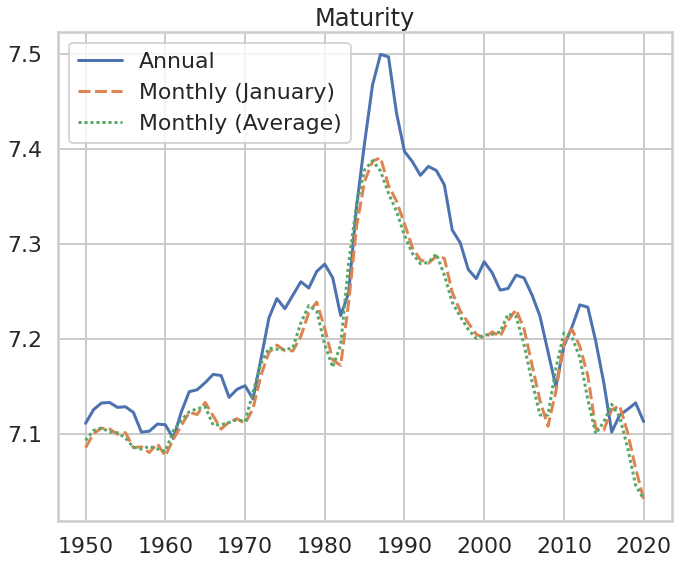

In [18]:
plot_all('Maturity', country_m, country_a)

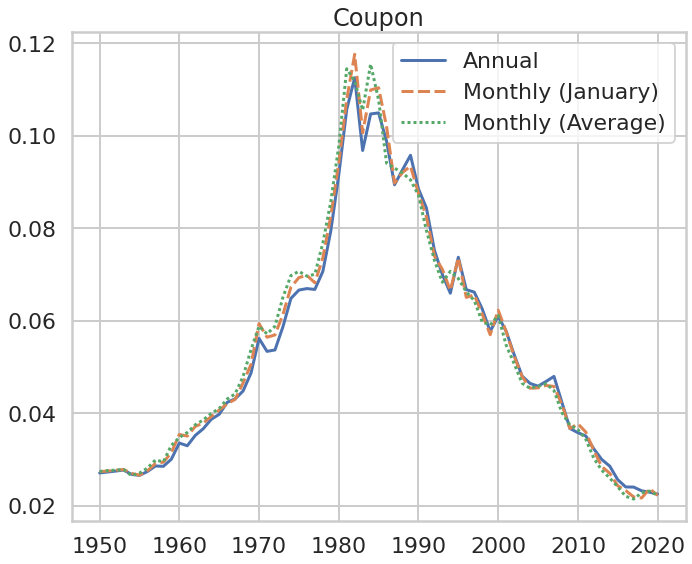

In [19]:
plot_all('Coupon', country_m, country_a)

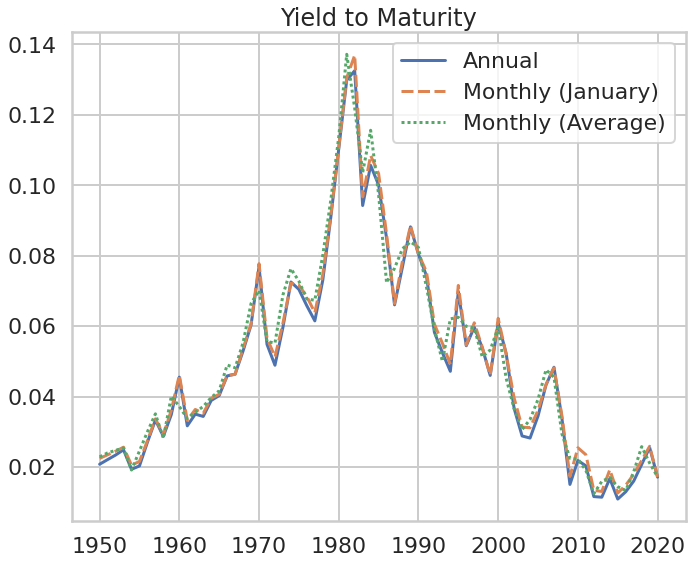

In [20]:
plot_all('YTM', country_m, country_a, title='Yield to Maturity')

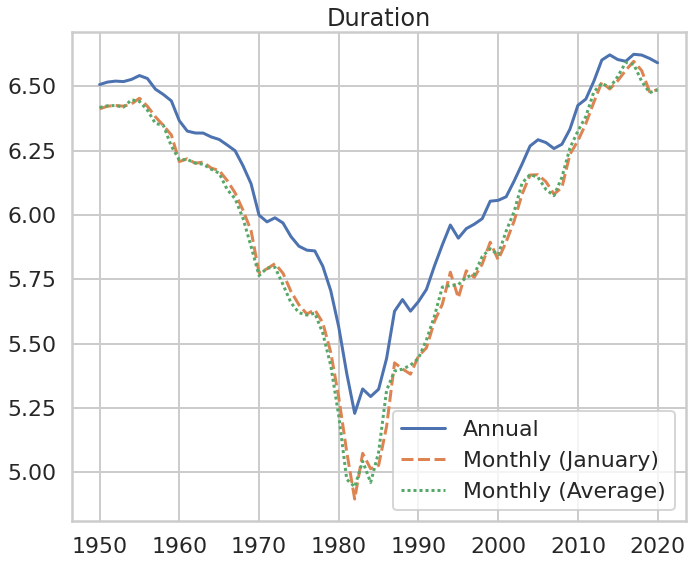

In [21]:
plot_all('Duration', country_m, country_a)